# Basic Walk-Through: k-nearest Neighbors


This notebook contains several examples that illustrate the machine learning workflow using a dataset of house prices.

We will use the fairly straightforward [k-nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) (KNN) algorithm that allows us to tackle both regression and classification problems.

In its default sklearn implementation, it identifies the k nearest data points (based on the Euclidean distance) to make a prediction. It predicts the most frequent class among the neighbors or the average outcome in the classification or regression case, respectively.


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

In [3]:
sns.set_style("whitegrid")

## Get the Data


### Kings County Housing Data


Data from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction)

Download via API:

`kaggle datasets download -d harlfoxem/housesalesprediction`


In [4]:
DATA_PATH = Path("../data")

In [5]:
house_sales = pd.read_csv("kc_house_data.csv")
house_sales = house_sales.drop(["id", "zipcode", "lat", "long", "date"], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


## Select & Transform Features


### Asset Prices often have long tails


查看原始标签 Y 的分布


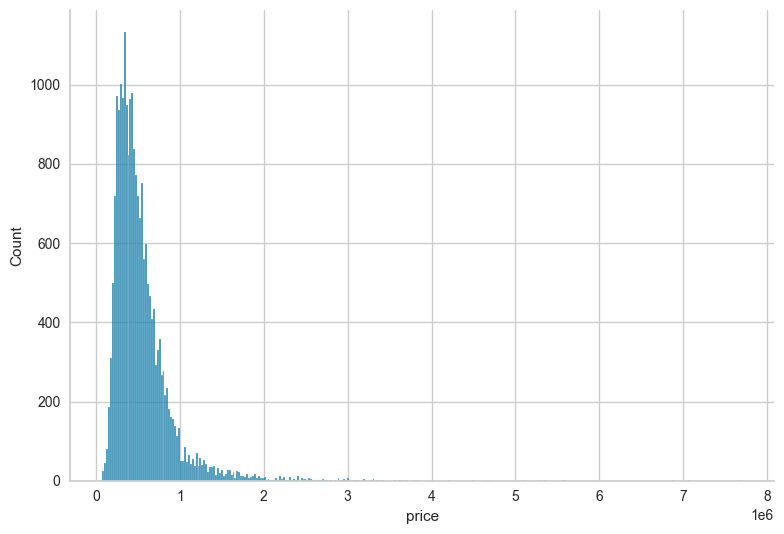

In [6]:
sns.histplot(house_sales.price)
sns.despine()
plt.tight_layout()
plt.show()

### Use log-transform


Useful for dealing with [skewed data](http://onlinestatbook.com/2/transformations/log.html).


`log` 变换用于减少数据的倾斜程度


In [7]:
house_sales

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,1410,1287


In [8]:
X_all = house_sales.drop("price", axis=1)
y = np.log(house_sales.price)

### Mutual information regression


See sklearn [docs](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Covered later in Chapter 6 of the book.


取与标签 Y 最相关的十个特征


In [9]:
mi_reg = pd.Series(mutual_info_regression(X_all, y), index=X_all.columns).sort_values(
    ascending=False
)
mi_reg

sqft_living      0.349332
grade            0.342768
sqft_living15    0.273139
sqft_above       0.258885
bathrooms        0.205770
bedrooms         0.087218
sqft_lot15       0.084056
yr_built         0.077284
floors           0.073686
sqft_basement    0.070598
sqft_lot         0.061910
view             0.057892
condition        0.015107
waterfront       0.010213
yr_renovated     0.010163
dtype: float64

In [10]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

### Bivariate Scatter Plots


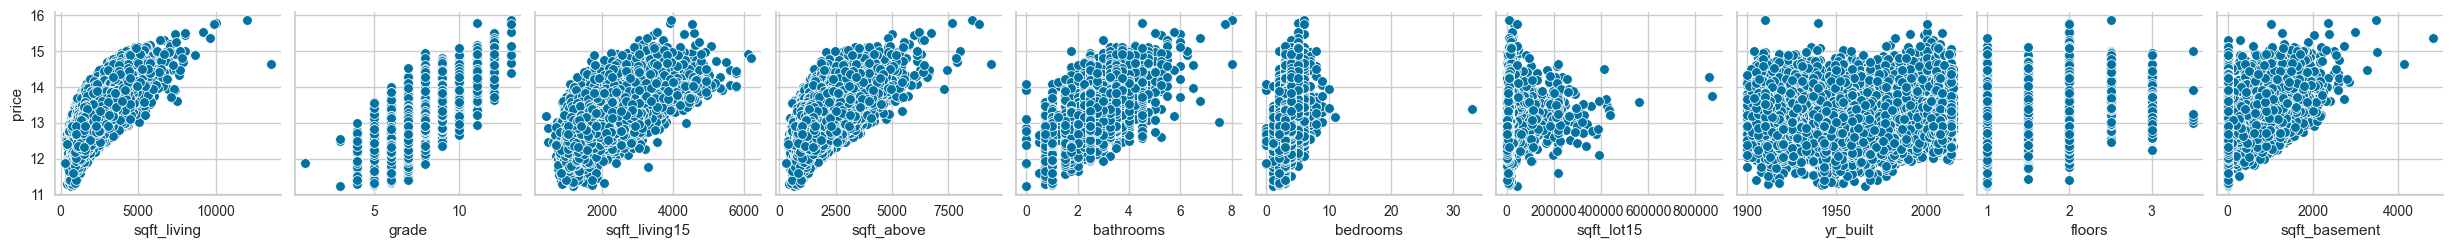

In [11]:
g = sns.pairplot(X.assign(price=y), y_vars=["price"], x_vars=X.columns)
sns.despine()
plt.show()

### Explore Correlations


探索斯皮尔曼相关性（顺序相关）


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  int64  
 1   grade          21613 non-null  int64  
 2   sqft_living15  21613 non-null  int64  
 3   sqft_above     21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   bedrooms       21613 non-null  int64  
 6   sqft_lot15     21613 non-null  int64  
 7   yr_built       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   sqft_basement  21613 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.6 MB


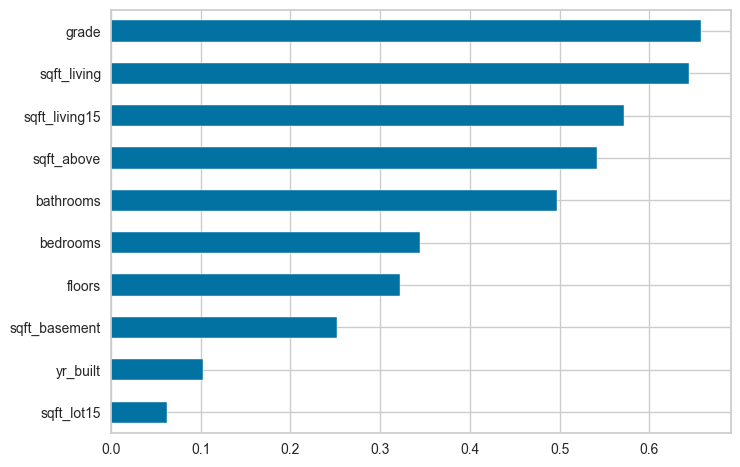

In [13]:
correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh()
plt.show()

## KNN Regression


### In-sample performance with default settings


KNN uses distance to make predictions; it requires standardization of variables to avoid undue influence based on scale


数据标准化（归一化）


In [14]:
X

,sqft_living,grade,sqft_living15,sqft_above,bathrooms,bedrooms,sqft_lot15,yr_built,floors,sqft_basement
0,1180,7,1340,1180,1.00,3,5650,1955,1.0,0
1,2570,7,1690,2170,2.25,3,7639,1951,2.0,400
2,770,6,2720,770,1.00,2,8062,1933,1.0,0
3,1960,7,1360,1050,3.00,4,5000,1965,1.0,910
4,1680,8,1800,1680,2.00,3,7503,1987,1.0,0
...,...,...,...,...,...,...,...,...,...,...
21608,1530,8,1530,1530,2.50,3,1509,2009,3.0,0
21609,2310,8,1830,2310,2.50,4,7200,2014,2.0,0
21610,1020,7,1020,1020,0.75,2,2007,2009,2.0,0
21611,1600,8,1410,1600,2.50,3,1287,2004,2.0,0


In [15]:
X_scaled = scale(X)

In [16]:
X_scaled

array([[-0.97983502, -0.55883575, -0.9433552 , ..., -0.54489777,
        -0.915427  , -0.65868104],
       [ 0.53363434, -0.55883575, -0.43268619, ..., -0.6810785 ,
         0.93650577,  0.2451414 ],
       [-1.42625404, -1.40958711,  1.07013975, ..., -1.29389179,
        -0.915427  , -0.65868104],
       ...,
       [-1.15404732, -0.55883575, -1.41025258, ...,  1.29354209,
         0.93650577, -0.65868104],
       [-0.52252773,  0.29191561, -0.8412214 , ...,  1.12331618,
         0.93650577, -0.65868104],
       [-1.15404732, -0.55883575, -1.41025258, ...,  1.25949691,
         0.93650577, -0.65868104]])

In [17]:
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)

KNeighborsRegressor()

In [18]:
y_pred = model.predict(X_scaled)

### Regression Error Metrics


In [19]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_squared_log_error,
    median_absolute_error,
    explained_variance_score,
    r2_score,
)

#### Computing the prediction error


The error is the deviation from the true value, whereas a residual is the deviation from an estimated value, e.g., an estimate of the population mean.


模型评估


In [20]:
error = (y - y_pred).rename("Prediction Errors")

In [21]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred),
)

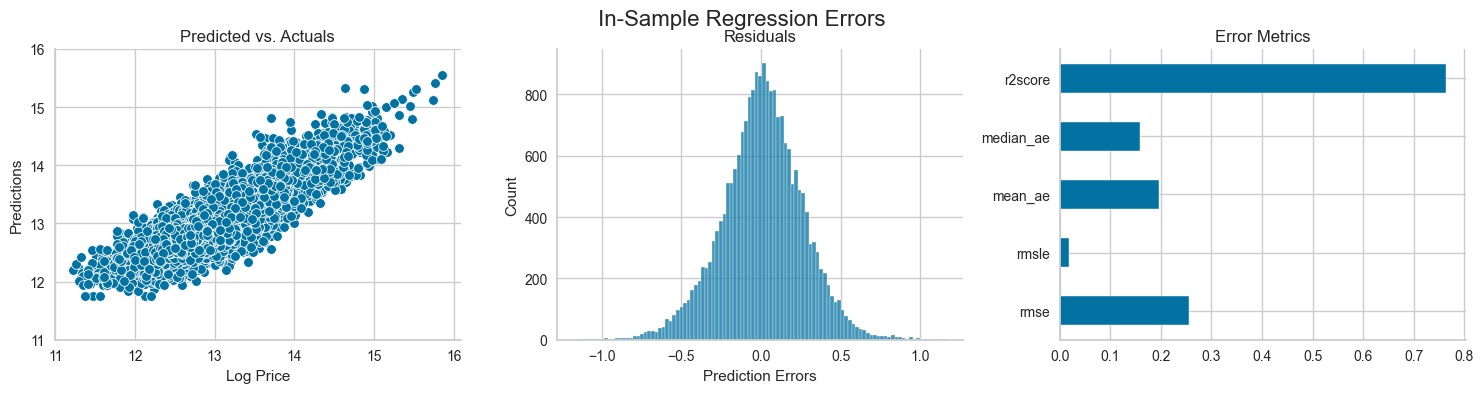

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel("Log Price")
axes[0].set_ylabel("Predictions")
axes[0].set_ylim(11, 16)
axes[0].set_title("Predicted vs. Actuals")
sns.histplot(error, ax=axes[1])
axes[1].set_title("Residuals")
pd.Series(scores).plot.barh(ax=axes[2], title="Error Metrics")
fig.suptitle("In-Sample Regression Errors", fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

### Cross-Validation


Manual hyperparameter tuning; using [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) ensures proper scaling for each fold using train metrics to standardize test data.


In [23]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))


rmse_score = make_scorer(rmse)

In [24]:
cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline(
        [("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=n))]
    )
    cv_rmse[n] = cross_val_score(pipe, X=X, y=y, scoring=rmse_score, cv=5)

In [27]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient="index")
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns = ["n", "fold", "RMSE"]

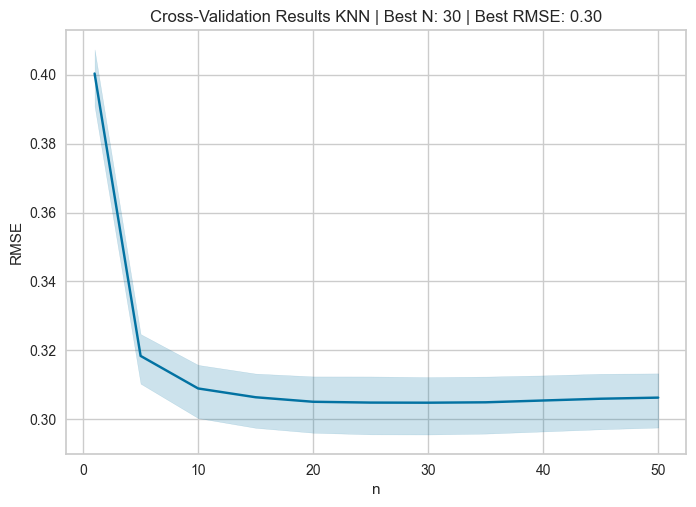

In [28]:
ax = sns.lineplot(x="n", y="RMSE", data=cv_rmse)
ax.set_title(
    f"Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}"
)
plt.show()

#### Actuals vs Predicted


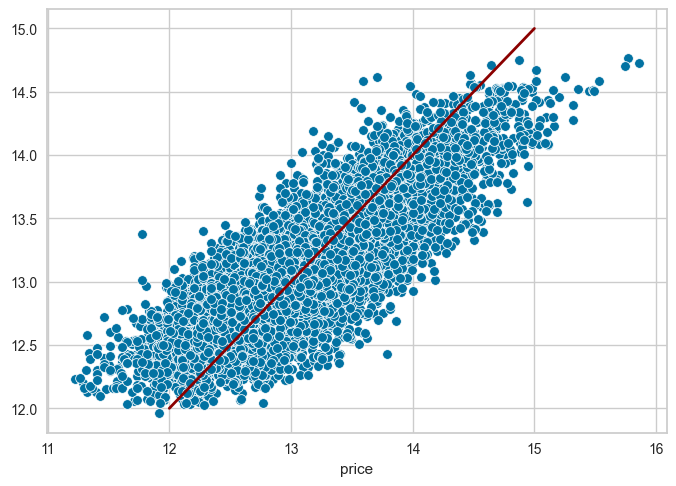

In [29]:
pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=best_n))]
)
y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c="darkred")
plt.show()

#### Cross-Validation Errors


In [30]:
error = (y - y_pred).rename("Prediction Errors")

In [31]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred),
)

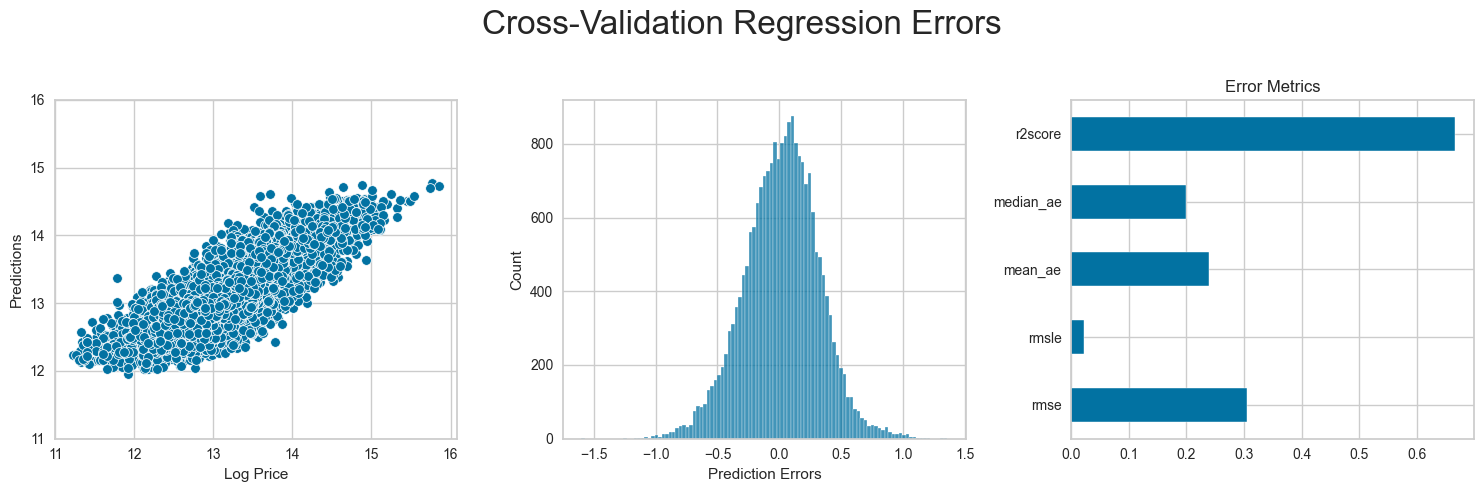

In [32]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel("Log Price")
axes[0].set_ylabel("Predictions")
axes[0].set_ylim(11, 16)
sns.histplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title="Error Metrics")
fig.suptitle("Cross-Validation Regression Errors", fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

### GridSearchCV with Pipeline


See sklearn [docs](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator).


In [33]:
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {"knn__n_neighbors": n_neighbors}

estimator = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=n_folds,
    scoring=rmse_score,
    #                          n_jobs=-1
)
estimator.fit(X=X, y=y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse, response_method='predict'))

In [34]:
cv_results = estimator.cv_results_

In [35]:
test_scores = (
    pd.DataFrame(
        {fold: cv_results[f"split{fold}_test_score"] for fold in range(n_folds)},
        index=n_neighbors,
    )
    .stack()
    .reset_index()
)
test_scores.columns = ["k", "fold", "RMSE"]

In [36]:
mean_rmse = test_scores.groupby("k").RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

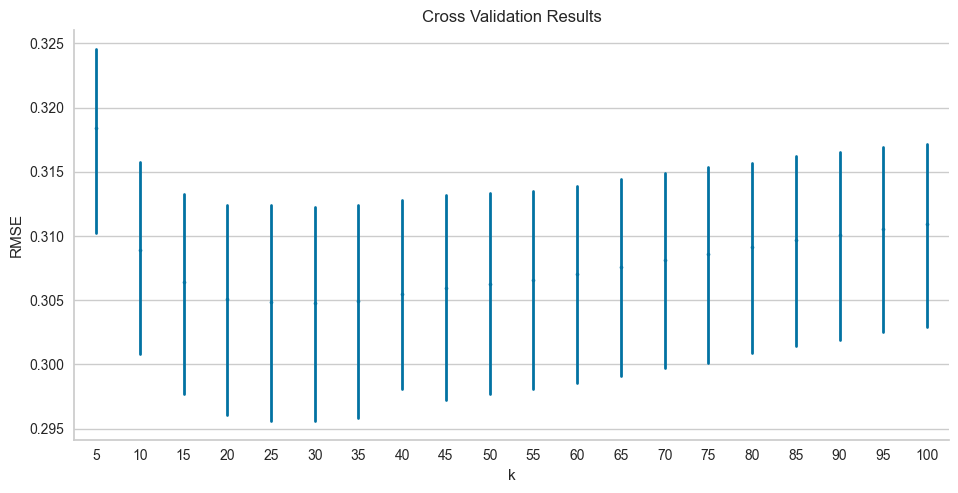

In [37]:
sns.pointplot(x="k", y="RMSE", data=test_scores, scale=0.3, join=False, errwidth=2)
plt.title("Cross Validation Results")
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.show()

### Train & Validation Curves mit yellowbricks


See background on [learning curves](https://en.wikipedia.org/wiki/Learning_curve) and yellowbrick [docs](https://www.scikit-yb.org/en/latest/).


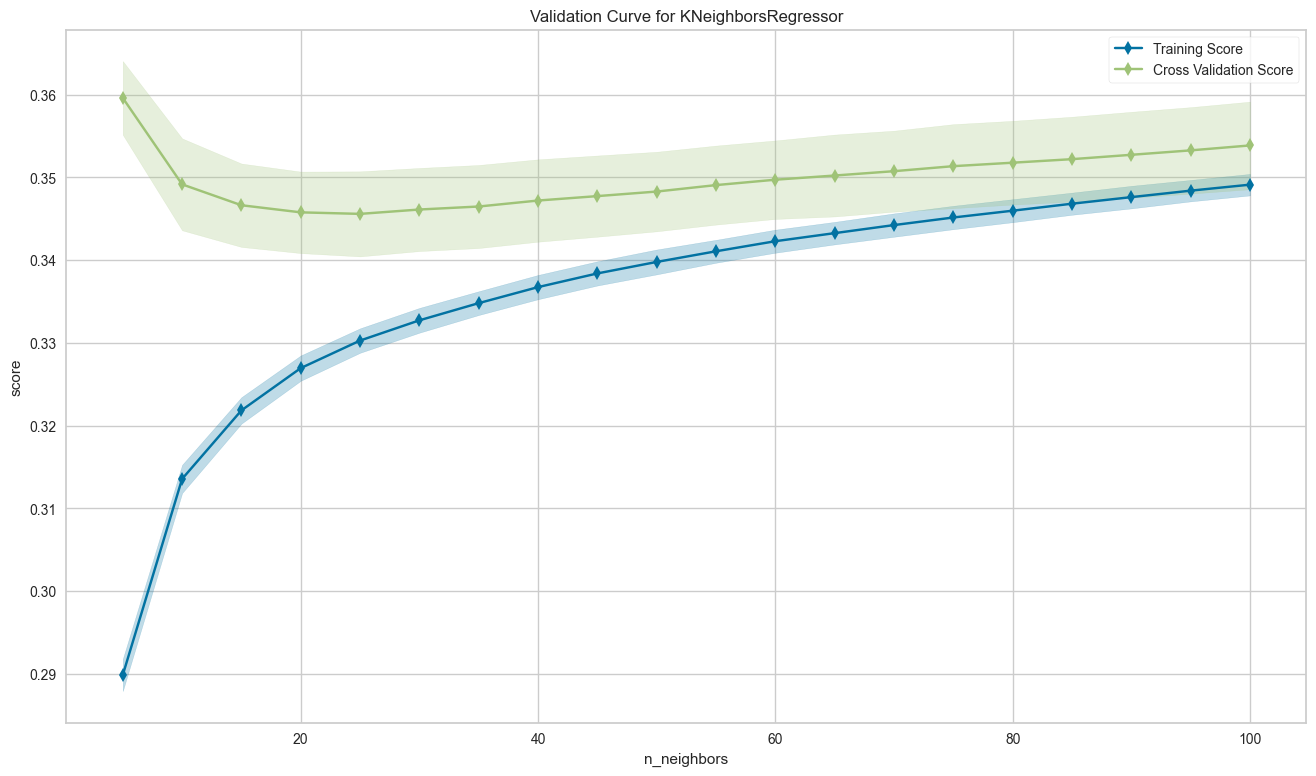

<Figure size 800x550 with 0 Axes>

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(
    KNeighborsRegressor(),
    param_name="n_neighbors",
    param_range=n_neighbors,
    cv=5,
    scoring=rmse_score,
    #                       n_jobs=-1,
    ax=ax,
)
val_curve.fit(X, y)
val_curve.poof()
sns.despine()
fig.tight_layout()
plt.show()

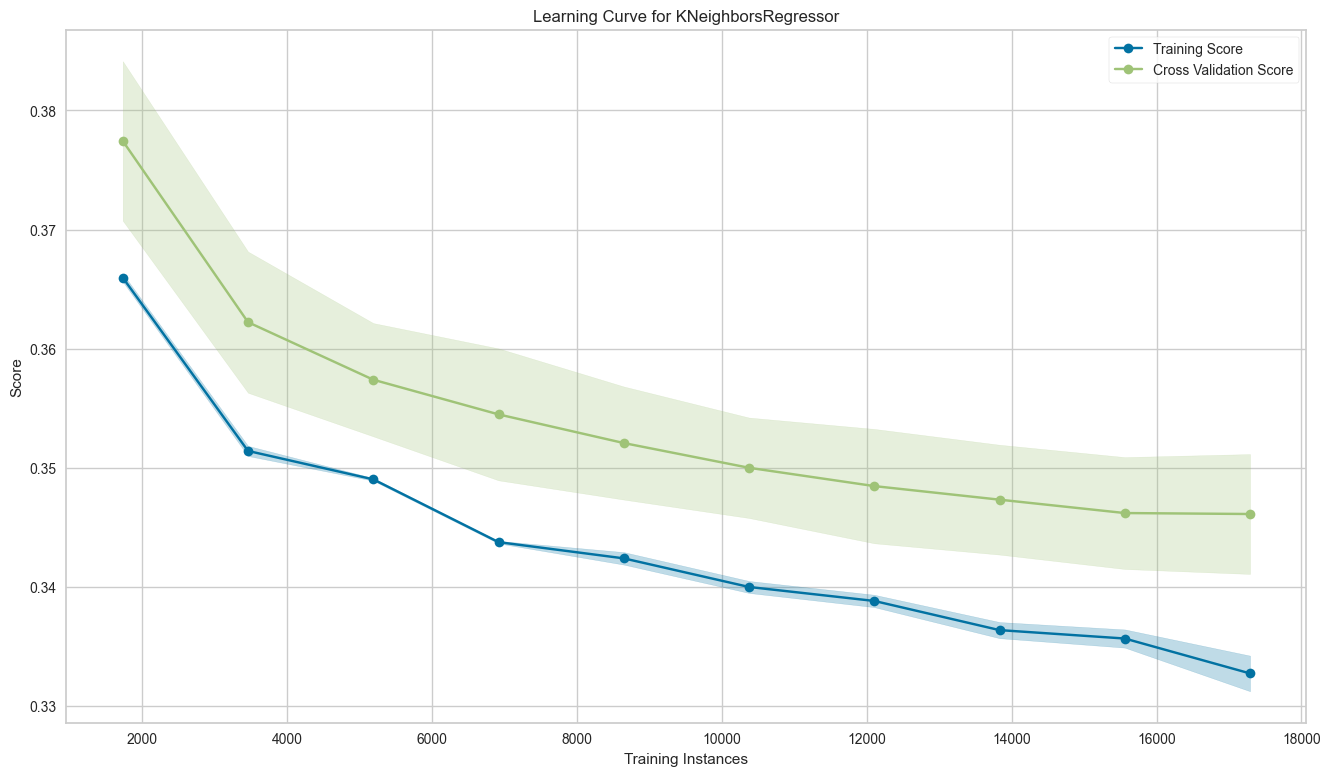

<Figure size 800x550 with 0 Axes>

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(
    KNeighborsRegressor(n_neighbors=best_k),
    train_sizes=np.arange(0.1, 1.01, 0.1),
    scoring=rmse_score,
    cv=5,
    #                         n_jobs=-1,
    ax=ax,
)
l_curve.fit(X, y)
l_curve.poof()
sns.despine()
fig.tight_layout()
plt.show()

## Binary Classification


In [40]:
y_binary = (y > y.median()).astype(int)

In [41]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = "roc_auc"

In [42]:
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

param_grid = {"knn__n_neighbors": n_neighbors}

estimator = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=n_folds,
    scoring=scoring,
    #                          n_jobs=-1
)
estimator.fit(X=X, y=y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

In [43]:
best_k = estimator.best_params_["knn__n_neighbors"]

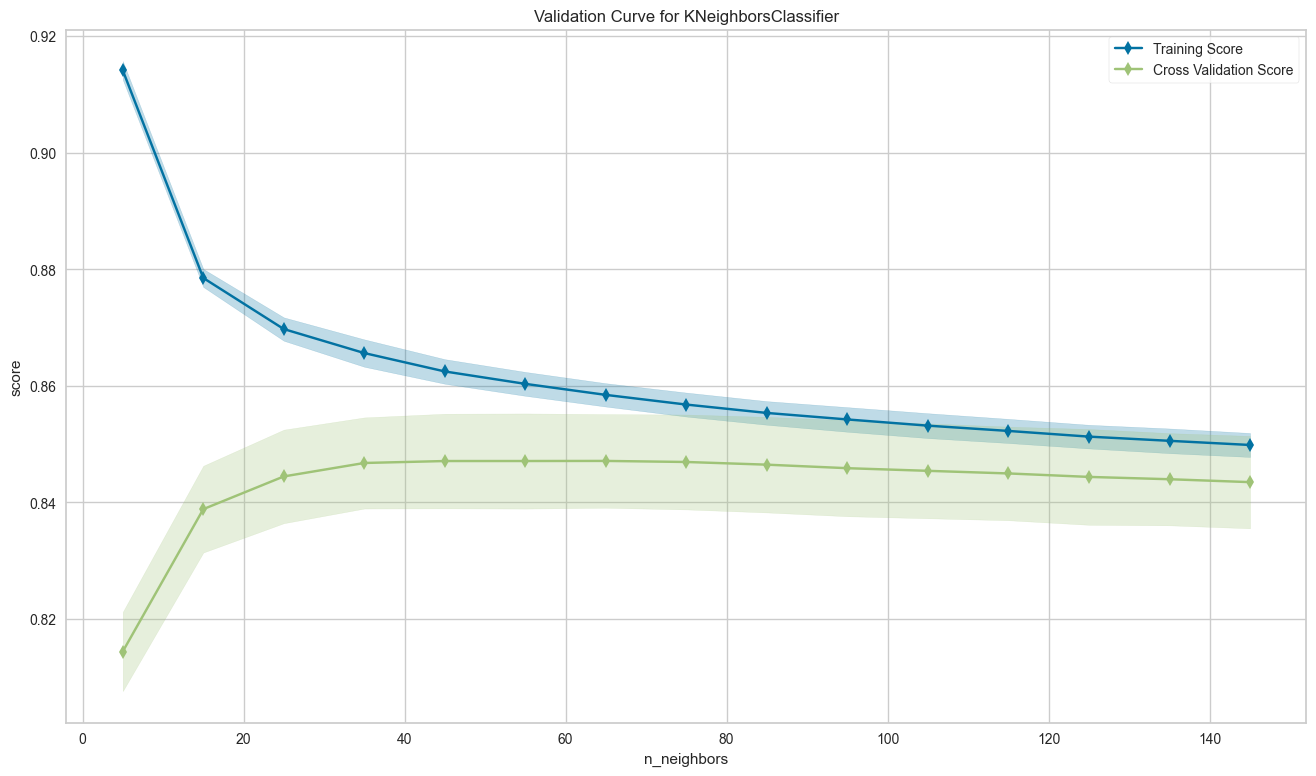

<Figure size 800x550 with 0 Axes>

In [44]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(
    KNeighborsClassifier(),
    param_name="n_neighbors",
    param_range=n_neighbors,
    cv=n_folds,
    scoring=scoring,
    #                       n_jobs=-1,
    ax=ax,
)
val_curve.fit(X, y_binary)
val_curve.poof()
sns.despine()
fig.tight_layout()
plt.show()

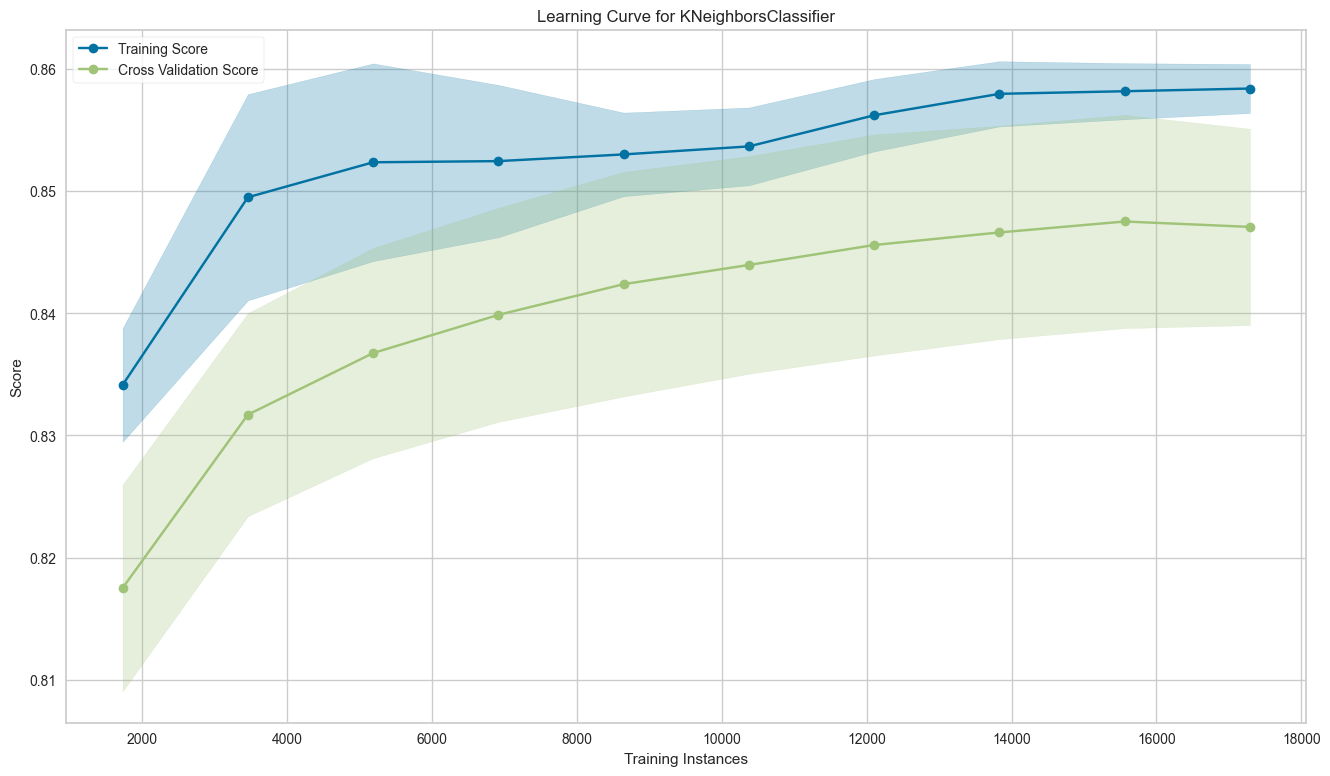

<Figure size 800x550 with 0 Axes>

In [45]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(
    KNeighborsClassifier(n_neighbors=best_k),
    train_sizes=np.arange(0.1, 1.01, 0.1),
    scoring=scoring,
    cv=5,
    #                         n_jobs=-1,
    ax=ax,
)
l_curve.fit(X, y_binary)
l_curve.poof()
sns.despine()
fig.tight_layout()
plt.show()

### Classification Metrics


See sklearn [docs](https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation-quantifying-the-quality-of-predictions) for details.


In [46]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    zero_one_loss,
    roc_auc_score,
    roc_curve,
    brier_score_loss,
    cohen_kappa_score,
    confusion_matrix,
    fbeta_score,
    hamming_loss,
    hinge_loss,
    jaccard_score,
    log_loss,
    matthews_corrcoef,
    f1_score,
    average_precision_score,
    precision_recall_curve,
)

| Name                                                             | API                                      |
| :--------------------------------------------------------------- | ---------------------------------------- |
| Area Under the Receiver Operating Characteristic Curve (ROC AUC) | roc_auc_score(y_true, y_score[, …])      |
| Receiver operating characteristic (ROC)                          | roc_curve(y_true, y_score[, …])          |
| Average precision (AP)                                           | average_precision_score(y_true, y_score) |
| Precision-recall pairs                                           | precision_recall_curve(y_true, …)        |
| Precision, recall, F-measure and support                         | precision_recall_fscore_support(…)       |
| F1 Score                                                         | f1_score(y_true, y_pred[, labels, …])    |
| F-beta Score                                                     | fbeta_score(y_true, y_pred, beta[, …])   |
| Precision                                                        | precision_score(y_true, y_pred[, …]      |
| Recall                                                           | recall_score(y_true, y_pred[, …])        |
| Main classification metrics                                      | classification_report(y_true, y_pred)    |
| confusion matrix                                                 | confusion_matrix(y_true, y_pred[, …])    |
| Accuracy classification score                                    | accuracy_score(y_true, y_pred)           |
| Zero-one classification loss                                     | zero_one_loss(y_true, y_pred[, …])       |
| Average Hamming loss                                             | hamming_loss(y_true, y_pred[, …])        |
| Brier score                                                      | brier_score_loss(y_true, y_prob[, …])    |
| Cohen’s kappa                                                    | cohen_kappa_score(y1, y2[, labels, …])   |
| Average hinge loss                                               | hinge_loss(y_true, pred_decision[, …])   |
| Jaccard similarity coefficient                                   | jaccard_similarity_score(y_true, y_pred) |
| Log loss, aka logistic loss or cross-entropy loss                | log_loss(y_true, y_pred[, eps, …])       |
| Matthews correlation coefficient (MCC)                           | matthews_corrcoef(y_true, y_pred[, …])   |


In [47]:
y_score = cross_val_predict(
    KNeighborsClassifier(best_k),
    X=X,
    y=y_binary,
    cv=5,
    n_jobs=-1,
    method="predict_proba",
)[:, 1]

#### Using Predicted Probabilities


In [48]:
pred_scores = dict(y_true=y_binary, y_score=y_score)

##### ROC AUC


In [49]:
roc_auc_score(**pred_scores)

0.8460225553056894

In [50]:
cols = ["False Positive Rate", "True Positive Rate", "threshold"]
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

##### Precision-Recall


In [51]:
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({"Precision": precision, "Recall": recall})

##### F1 Score - Optimize Threshold


In [52]:
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score > t) for t in ts})
best_threshold = f1.idxmax()

##### Plot


In [53]:
roc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  67 non-null     float64
 1   True Positive Rate   67 non-null     float64
 2   threshold            67 non-null     float64
dtypes: float64(3)
memory usage: 1.7 KB


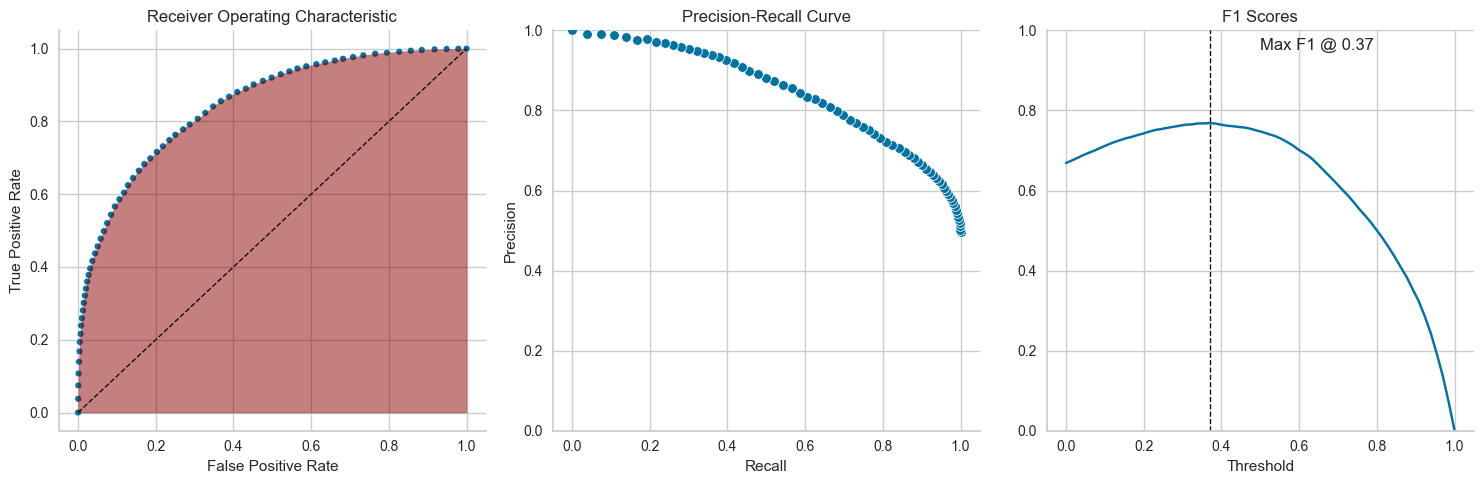

In [54]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(
    x="False Positive Rate",
    y="True Positive Rate",
    data=roc,
    size=5,
    legend=False,
    ax=axes[0],
)
axes[0].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="k", ls="--", lw=1)
axes[0].fill_between(
    y1=roc["True Positive Rate"],
    x=roc["False Positive Rate"],
    alpha=0.5,
    color="darkred",
)
axes[0].set_title("Receiver Operating Characteristic")


sns.scatterplot(x="Recall", y="Precision", data=pr_curve, ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title("Precision-Recall Curve")


f1.plot(ax=axes[2], title="F1 Scores", ylim=(0, 1))
axes[2].set_xlabel("Threshold")
axes[2].axvline(best_threshold, lw=1, ls="--", color="k")
axes[2].text(s=f"Max F1 @ {best_threshold:.2f}", x=0.5, y=0.95)
sns.despine()
fig.tight_layout()
plt.show()

##### Average Precision


In [55]:
average_precision_score(y_true=y_binary, y_score=y_score)

0.848419175657455

##### Brier Score


In [56]:
brier_score_loss(y_true=y_binary, y_prob=y_score)

0.16022812262069974

#### Use Predictions after thresholding


In [57]:
y_pred = y_score > best_threshold

In [58]:
scores = dict(y_true=y_binary, y_pred=y_pred)

##### F-beta Score


In [59]:
fbeta_score(**scores, beta=1)

0.7684210526315789

In [60]:
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

    accuracy                           0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613



##### Confusion Matrix


In [61]:
confusion_matrix(**scores)

array([[6871, 3993],
       [1551, 9198]], dtype=int64)

##### Accuracy


In [62]:
accuracy_score(**scores)

0.743487715726646

##### Zero-One Loss


In [63]:
zero_one_loss(**scores)

0.25651228427335404

##### Hamming Loss


Fraction of labels that are incorrectly predicted


In [64]:
hamming_loss(**scores)

0.256512284273354

##### Cohen's Kappa


Score that expresses the level of agreement between two annotators on a classification problem.


In [65]:
cohen_kappa_score(y1=y_binary, y2=y_pred)

0.4875770533373557

##### Hinge Loss


In [66]:
hinge_loss(y_true=y_binary, pred_decision=y_pred)

0.7591727201221488

##### Jaccard Similarity


In [67]:
jaccard_score(**scores)

0.6239316239316239

##### Log Loss / Cross Entropy Loss


In [68]:
log_loss(**scores)

9.24563986439946

##### Matthews Correlation Coefficient


In [69]:
matthews_corrcoef(**scores)

0.5004925066659417

## Multi-Class


In [70]:
y_multi = pd.qcut(y, q=3, labels=[0, 1, 2])

In [71]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = "accuracy"

In [72]:
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

param_grid = {"knn__n_neighbors": n_neighbors}

estimator = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=n_folds, n_jobs=-1)
estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)})

In [73]:
y_pred = cross_val_predict(
    estimator.best_estimator_, X=X, y=y_multi, cv=5, n_jobs=-1, method="predict"
)

In [74]:
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7226
           1       0.52      0.52      0.52      7223
           2       0.77      0.74      0.75      7164

    accuracy                           0.65     21613
   macro avg       0.65      0.65      0.65     21613
weighted avg       0.65      0.65      0.65     21613

